Muhammad Irfan Hilman

FTDS Batch 16

# I. Perkenalan


Seorang data scientist ditugaskan untuk menganalisa dataset sensus kependudukan. Tujuan dari kegiatan tsb adalah untuk menyelidiki hubungan antara tingkat penghasilan dengan parameter2 terkait seperti umur, pekerjaan, pendidikan, status, ras, jenis kelamin, jam kerja dan asal negara. Diharapkan dari analisa tsb diperoleh insight2 penting untuk nantinya digunakan pemerintah untuk membuat kebijakan membangun perekonomian. 

Kegiatan analisa menggunakan metode regresi logistik dan support vector machine (SVM) dengan menggunakan bauran data numerik dan kategorikal. Target yang digunakan adalah penghasilan yang dibagi menjadi diatas 50,000 USD (>50K) dan dibawah 50,000 USD (<=50K) sehingga digolongkan sebagai data kategorikal. Di sisi lain, fitur yang digunakan berupa data numerik dan kategorikal sehingga harus melalui fase pemrosesan seperti scaling dan encoding. Dataset yang digunakan adalah ml_datasets.census_adult_income yang berasal dari bigquery-public-data. Untuk mencari metode terbaik akan dilakukan beberapa variasi hyperparameter dari SVM, yaitu kernel rbf, linear dan polynomial dengan C=1 dan C=100. Hasil dari SVM ini juga akan dibandingkan dengan hasil dari regresi logistik menggunakan analisa statistik dari model performance.

Pertama2, untuk mendownload dataset dari Big Query akan digunakan melalui code SQL berikut:

SELECT age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket, 

FROM `bigquery-public-data.ml_datasets.census_adult_income`

WHERE workclass NOT LIKE '%?%'

AND hours_per_week < 100

LIMIT 19930


# II. Import Libraries

Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [1]:
# Install package feature-engine untuk keperluan handling outlier
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 12.0 MB/s 


In [2]:
# Import library2 yang dibutuhkan 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# III. Data Loading

Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [5]:
# Load dataset h8dsft_P1G2_Irfan_Hilman.csv yang sudah diupload ke repo GitHub. Store dataset ke dalam df
df = pd.read_csv('https://raw.githubusercontent.com/IrfanHilman/FTDS_Hacktiv8_Batch_16/main/h8dsft_P1G2_Irfan_Hilman.csv')

# Tampilkan 5 baris pertama
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K


In [6]:
# Tampilkan 5 baris terakhir
df.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
19925,25,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,40,United-States,<=50K
19926,23,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
19927,46,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,40,United-States,<=50K
19928,40,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
19929,59,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,>50K


In [7]:
# Delete missing values dari df
df.dropna(inplace=True)

Selanjutnya kita akan mencari apakah ada label2 lain dalam dataset yang tidak standar. Misalnya '?' pada kolom occupation dan native_country

In [8]:
# Hitung jumlah masing2 label pada kolom occupation
df.occupation.value_counts()

 Adm-clerical         3328
 Craft-repair         3032
 Other-service        2982
 Prof-specialty       2708
 Sales                2377
 Exec-managerial      2249
 Tech-support          758
 Farming-fishing       620
 Protective-serv       524
 Transport-moving      519
 Handlers-cleaners     407
 Machine-op-inspct     283
 Priv-house-serv       130
 ?                       7
 Armed-Forces            6
Name: occupation, dtype: int64

Terdapat 7 baris data berisi '?'. Karena proporsi ini cukup kecil, akan dilakukan penghapusan data

In [9]:
# Delete baris yang mengandung label '?' dalam kolom occupation
df = df.drop(df.index[[list(df.loc[df['occupation'].str.contains('\?', case=False)].index)]])

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Kita juga akan mengecek data '?'pada kolom native_country

In [10]:
# Menghitung jumlah masing2 label pada kolom native_country
df.native_country.value_counts()

 United-States                 17777
 Mexico                          395
 ?                               354
 Philippines                     153
 Puerto-Rico                      84
 El-Salvador                      75
 Canada                           71
 Germany                          70
 India                            68
 Jamaica                          67
 Cuba                             67
 England                          56
 Vietnam                          51
 China                            49
 South                            43
 Dominican-Republic               42
 Japan                            40
 Italy                            39
 Guatemala                        39
 Poland                           34
 Haiti                            33
 Taiwan                           32
 Columbia                         32
 Iran                             24
 Nicaragua                        22
 Peru                             21
 Portugal                         20
 

Data '?' termasuk dalam 3 label teratas dengan jumlah terbesar, meskipun jaraknya sangat jauh dari label 'United-States'. Oleh karena itu, data tidak perlu dihapus namun diganti dengan 'United-States' karena label 'United-States' adalah modus data pada kolom native_country

In [11]:
# Ubah data '?' dengan 'United-States' pada kolom native_country
df.loc[df['native_country'].str.contains('\?'), 'native_country'] = ' United-States'

# IV. EDA

Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.

In [12]:
# Tampilkan lagi head dari df
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,United-States,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K
5,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K


Pada bagian ini kita akan membedah informasi mengenai masing2 kolom, dimulai dari kolom 'age'

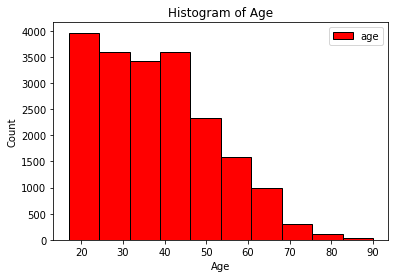

In [13]:
# Plot kolom 'age' dalam bentuk histogram 
plt.hist(df.age, 
         histtype ='bar', color='r', edgecolor='k')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(['age'], loc='upper right')

Terlihat jika dataset didominasi oleh responden berusia muda, yakni antara 20-40 tahun. Hal ini cukup mewakili karena rentang umur tsb merupakan usia produktif. Berikutnya kita akan melihat persebaran data pada kolom 'workclass'

<ipython-input-14-8621f29d86a1>:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['workclass'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


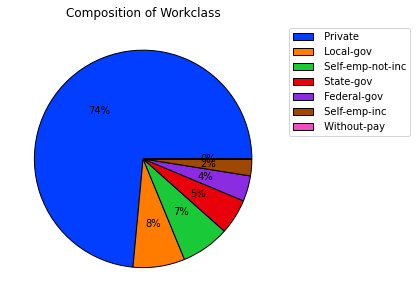

In [14]:
# Plot pie chart untuk kolom 'workclass'
palette_color = sns.color_palette('bright')
label1 = list(pd.DataFrame(df['workclass'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Workclass')
plt.pie(pd.DataFrame(df['workclass'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label1, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Sebagian besar responden bekerja di sektor swasta (Private), yakni 74%, diikuti dengan pegawai negeri (Local-gov) sebanyak 8% dan mandiri (Self-emp-not-inc) sebanyak 7%. Berikutnya kita akan menyelidiki data status pernikahan

<ipython-input-15-16577fe4d4ae>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['marital_status'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


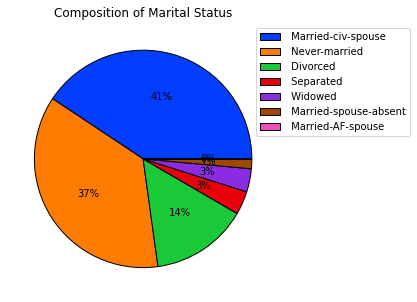

In [15]:
# Tampilkan pie chart dari kolom marital_status
label2 = list(pd.DataFrame(df['marital_status'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Marital Status')
plt.pie(pd.DataFrame(df['marital_status'].value_counts()),colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label2, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Sebagian besar responden sudah menikah (41%), namun cukup banyak responden yang belum menikah (37%). Hal ini cukup wajar karena sebagian besar responden berusia muda. Sebanyak 14% responden telah bercerai. Berikutnya, kita akan melihat data mengenai jenis pekerjaan.

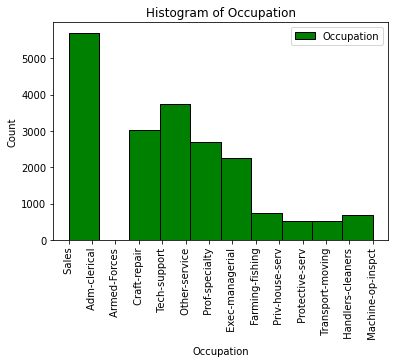

In [16]:
# Buat histogram untuk kolom occupation
plt.hist(df.occupation, 
         histtype ='bar', color='g', edgecolor='k')
plt.title('Histogram of Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(['Occupation'], loc='upper right')

Sebagian besar responden bekerja sebagai Sales dan sekretaris (Adm-clerical), diikuti dengan sektor jasa. Responden dengan jenis pekerjaan paling sedikit adalah tentara (Armed-Forces). Selanjutnya kita akan melihat data mengenai tingkat pendidikan responden.

<ipython-input-17-4167c9eeb859>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['education'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


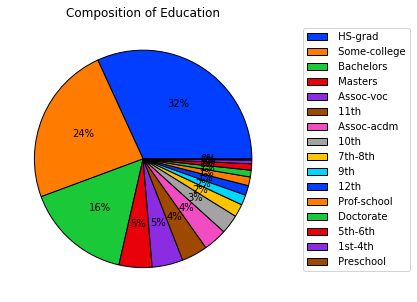

In [17]:
# Plot pie chart untuk kolom education
label22 = list(pd.DataFrame(df['education'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Education')
plt.pie(pd.DataFrame(df['education'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label22, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Sebagian besar responden adalah lulusan SMA (HS-grad) sebanyak 32%, lalu diikuti dengan S1 (24% dan 16%). Hanya sebagian kecil responden memiliki tingkat pendidikan pascasarjana (<8%).

Berikutnya kita ingin mengetahui komposisi ras dari responden

<ipython-input-18-240310208e9b>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['race'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


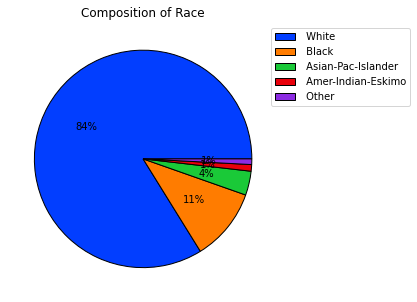

In [18]:
# Plot pie chart untuk kolom race
label3 = list(pd.DataFrame(df['race'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Race')
plt.pie(pd.DataFrame(df['race'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label3, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Sebagian besar responded merupakan ras kulit putih (White) yakni sebesar 84%, diikuti kulit hitam (Black) sebanyak 11%. Dari data ini, maka diperkirakan sebagian besar responden berasal dari Amerika Serikat atau negara2 Eropa. Berikutnya, kita akan melihat persebaran gender.

<ipython-input-19-3d686afc6d67>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['sex'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


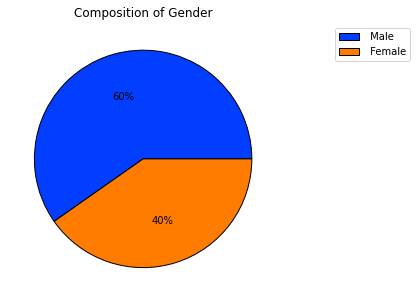

In [19]:
# Plot pie chart untuk kolom sex
label4 = list(pd.DataFrame(df['sex'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Gender')
plt.pie(pd.DataFrame(df['sex'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label4, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Dari pie chart diatas, 60% responden adalah laki2. Hal ini cukup wajar karena stereotype mengenai peran laki2 di tengah masyarakat adalah untuk bekerja. Melihat cukup banyak responden yang sudah menikah, diperkirakan jika sebagian wanita lebih memilih menjadi ibu rumah tangga. Berikutnya, kita akan melihat negara asal dari responden.

<ipython-input-20-0d6de53723b4>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['native_country'].value_counts().head(10)), labels=label44, colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


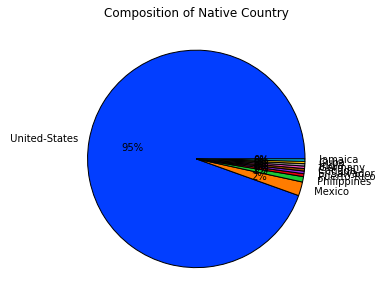

In [20]:
# Plot pie chart untuk kolom native_country
label44 = list(pd.DataFrame(df['native_country'].value_counts().head(10)).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Native Country')
plt.pie(pd.DataFrame(df['native_country'].value_counts().head(10)), labels=label44, colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.show()

Sesuai perkiraan sebelumnya, terlihat jika komposisi responden terbanyak adalah dari Amerika Serikat (95%). Oleh karena itu, analisa dan predictive model mengenai tingkat penghasilan dan parameter2 terkait dalam penelitian ini akan lebih banyak berlaku untuk masyarakat di Amerika Serikat. 

<ipython-input-21-4957e608aced>:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(pd.DataFrame(df['income_bracket'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})


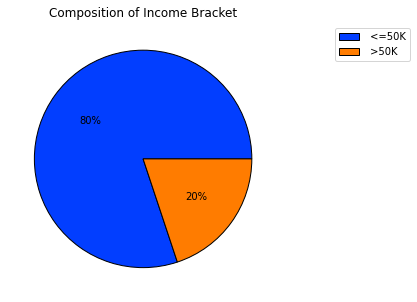

In [21]:
# Tampilkan pie chart komposisi income_bracket
label5 = list(pd.DataFrame(df['income_bracket'].value_counts()).index)
plt.figure(figsize = (5, 5))
plt.title('Composition of Income Bracket')
plt.pie(pd.DataFrame(df['income_bracket'].value_counts()), colors=palette_color, autopct='%.0f%%', wedgeprops={"edgecolor":"k"})
plt.legend(label5, loc='upper right',bbox_to_anchor=(1.5,1))
plt.show()

Terlihat dari diagram diatas, 80% dari responden memiliki income dibawah 50,000 USD

In [22]:
# Hitung jumlah masing2 label income_bracket
df.income_bracket.value_counts()

 <=50K    15959
 >50K      3964
Name: income_bracket, dtype: int64

In [23]:
# Hitung rata2 usia pada masing2 income bracket
df.groupby('income_bracket')['age'].mean()

income_bracket
 <=50K    36.381603
 >50K     44.724268
Name: age, dtype: float64

Terlihat jika rata2 usia berbanding lurus terhadap income. Rata2 usia pada income <= 50,000 USD adalah 36 tahun, sedangkan pada income > 50,000 USD adalah 44 tahun. Semakin bertambah usia, semakin besar income seseorang

In [24]:
# Kelompokkan jenis pekerjaan terhadap income bracket
df.groupby('income_bracket')['occupation'].value_counts()

income_bracket  occupation        
 <=50K           Adm-clerical         2934
                 Other-service        2881
                 Craft-repair         2436
                 Sales                1938
                 Prof-specialty       1684
                 Exec-managerial      1383
                 Farming-fishing       568
                 Tech-support          550
                 Transport-moving      428
                 Handlers-cleaners     396
                 Protective-serv       364
                 Machine-op-inspct     263
                 Priv-house-serv       129
                 Armed-Forces            5
 >50K            Prof-specialty       1024
                 Exec-managerial       866
                 Craft-repair          596
                 Sales                 439
                 Adm-clerical          394
                 Tech-support          208
                 Protective-serv       160
                 Other-service         101
                 Tr

Bisa dilihat jika sebagian besar jenis pekerjaan berpenghasilan tinggi adalah pekerjaan spesialis (Prof-specialty) dan eksekutif-manajer (Exec-managerial). Sementara itu, pekerjaan seperti administrasi (Adm-clerical), jasa (Other-service), pertukangan (Craft-repair) dan Sales cenderung memiliki income <= 50,000 USD. Meskipun demikian, sebagian orang yang bekerja di bidang pertukangan (Craft-repair) dan Sales juga ada yang berpenghasilan > 50,000 USD.

In [25]:
# Kelompokkan ras berdasarkan income bracket
df.groupby('income_bracket')['race'].value_counts()

income_bracket  race               
 <=50K           White                 13188
                 Black                  1910
                 Asian-Pac-Islander      530
                 Amer-Indian-Eskimo      177
                 Other                   154
 >50K            White                  3514
                 Black                   238
                 Asian-Pac-Islander      182
                 Amer-Indian-Eskimo       18
                 Other                    12
Name: race, dtype: int64

Secara keseluruhan, sulit ditarik hubungan antara ras dan penghasilan

In [26]:
# Kelompokkan gender berdasarkan income
df.groupby('income_bracket')['sex'].value_counts()

income_bracket  sex    
 <=50K           Male      8726
                 Female    7233
 >50K            Male      3177
                 Female     787
Name: sex, dtype: int64

Disini kita bisa melihat jika laki2 cenderung memiliki income lebih besar dari wanita. Pada income bracket >50,000 USD, proporsi laki2 jauh lebih besar dibandingkan dengan wanita.

In [27]:
# Kelompokkan asal negara berdasarkan income
income_native = pd.DataFrame(df.groupby('income_bracket')['native_country'].value_counts())

In [28]:
# Tampilkan urutan negara teratas dengan income <= 50,000 USD
income_native.loc[' <=50K'].head()

,native_country
native_country,
United-States,14464
Mexico,377
Philippines,104
Puerto-Rico,76
El-Salvador,71


Amerika Serikat menempati urutan teratas pada asal negara dengan penghasilan <= 50,000 USD. Namun, tidak berarti Amerika Serikat cenderung berpenghasilan rendah. Untuk membuktikannya, mari kita check urutan negara teratas dengan penghasilan > 50,000 USD

In [29]:
income_native.loc[' >50K'].head()

,native_country
native_country,
United-States,3667
Philippines,49
India,23
England,19
Canada,18


Terlihat jika Amerika Serikat juga mendominasi pada asal negara dengan penghasilan >50,000 USD. Oleh karena itu, sulit disimpulkan mengenai hubungan antara negara asal dan income.

# V. Data Preprocessing

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

Pada bagian sebelumnya telah dilakukan EDA untuk menganalisa secara garis besar hubungan masing2 variabel pada dataset. Sekarang saatnya melakukan preprocessing supaya dataset siap untuk menjalani proses pemodelan. Diantara langkah preprocessing tsb adalah feature selection, yakni seleksi terhadap fitur yang tidak berkorelasi thd target. Jumlah fitur harus dibatasi menjadi fitur2 yg memiliki korelasi tinggi dengan target, karena jika terlalu banyak dapat menyebabkan overfitting model.

In [30]:
# Tampilkan lagi 5 baris teratas pada df
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,United-States,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K
5,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K


Banyak angka 0 pada kolom capital_gain dan capital_loss. Angka tsb bukanlah data yg baik karena tidak bisa digunakan untuk memprediksi fitur. Mari kita lihat proporsi data dengan angka 0 pada masing2 kolom tsb.

In [31]:
# Hitung proporsi data dengan angka 0 pada kolom capital gain
print('Proportion of 0 capital gain data is:')
df.capital_gain.value_counts().head(1)[0]/df.capital_gain.value_counts().sum()

Proportion of 0 capital gain data is:


0.9288761732670783

In [32]:
# Hitung proporsi data dengan angka 0 pada kolom capital loss
print('Composition of 0 capital loss data is:')
df.capital_loss.value_counts().head(1)[0]/df.capital_loss.value_counts().sum()

Composition of 0 capital loss data is:


0.9580886412688852

Kedua hasil perhitungan diatas menandakan proporsi angka 0 sangatlah besar untuk masing2 kolom. Untuk kolom capital gain, proporsi angka 0 adalah 93% dan untuk kolom capital loss, proporsi adalah 96%. Oleh karena itu, kolom capital_gain dan capital_loss akan dihilangkan dari df karena sebagian besar hanya berisi angka 0.

In [33]:
# Hilangkan kolom capital_gain dan capital_loss pada df dan store hasilnya pada df_1
df_1 = df.drop(['capital_gain','capital_loss'], axis=1)

Mulai sekarang, df_1 akan digunakan untuk menyimpan dataset hasil feature selection. Selain issue mengenai fitur yang tidak berkorelasi, terdapat juga issue cardinality pada kolom kategorical dimana jumlah label unique terlalu banyak, sehingga perlu dikurangi untuk menghasilkan model yang good-fit. Oleh karena itu akan dilakukan proses cardinality reduction

In [34]:
# Tampilkan label unique pada df_1
df_1.select_dtypes(exclude='number').nunique()

workclass          7
education         16
marital_status     7
occupation        14
relationship       6
race               5
sex                2
native_country    40
income_bracket     2
dtype: int64

Cukup banyak cardinality pada masing2 kolom kategorikal

In [35]:
# Hitung jumlah label unik pada kolom education
df_1.education.value_counts()

 HS-grad         6344
 Some-college    4744
 Bachelors       3143
 Masters          976
 Assoc-voc        918
 11th             770
 Assoc-acdm       701
 10th             568
 7th-8th          380
 9th              302
 12th             288
 Prof-school      258
 Doctorate        200
 5th-6th          188
 1st-4th          108
 Preschool         35
Name: education, dtype: int64

Label pada kolom education akan direduksi menjadi: School, Bachelors, Vocation, Masters dan Doctorate.

In [36]:
# Kurangi cardinality pada kolom education
df_1[['education']] = df_1[['education']].replace([' HS-grad',' 11th',' 10th',' 7th-8th',' 9th',' 12th',
                                               ' 5th-6th',' 1st-4th',' Preschool'], ' School')
df_1[['education']] = df_1[['education']].replace([' Some-college',' Bachelors'], ' Bachelors')
df_1[['education']] = df_1[['education']].replace([' Assoc-voc',' Assoc-acdm',' Prof-school'], ' Vocation')

In [37]:
# Tampilkan kolom education
df_1.education.value_counts()

 School       8983
 Bachelors    7887
 Vocation     1877
 Masters       976
 Doctorate     200
Name: education, dtype: int64

Sekarang hanya ada 5 label pada kolom education

In [38]:
# Tampilkan jumlah masing2 label pada kolom workclass
df_1.workclass.value_counts()

 Private             14646
 Local-gov            1535
 Self-emp-not-inc     1437
 State-gov            1049
 Federal-gov           756
 Self-emp-inc          491
 Without-pay             9
Name: workclass, dtype: int64

Jumlah label akan dibatasi menjadi Private, Public Servant dan Self-Employed

In [39]:
# Kurangi cardinality pada kolom workclass
df_1[['workclass']] = df_1[['workclass']].replace([' Local-gov',' State-gov',' Federal-gov'], ' Public Servant')
df_1[['workclass']] = df_1[['workclass']].replace([' Self-emp-not-inc',' Self-emp-inc',' Without-pay'], ' Self-employed')

In [40]:
# Tampilkan kolom workclass hasil reduction
df_1.workclass.value_counts()

 Private           14646
 Public Servant     3340
 Self-employed      1937
Name: workclass, dtype: int64

In [41]:
# Tampilkan jumlah masing2 label pada kolom marital_status
df_1.marital_status.value_counts()

 Married-civ-spouse       8102
 Never-married            7276
 Divorced                 2876
 Separated                 693
 Widowed                   686
 Married-spouse-absent     275
 Married-AF-spouse          15
Name: marital_status, dtype: int64

Cardinality pada kolom marital_status akan dikurangi menjadi Married, Never Married dan Previously Married.

In [42]:
# Kurangi cardinality pada kolom marital_status
df_1[['marital_status']] = df_1[['marital_status']].replace([' Married-civ-spouse',' Married-spouse-absent',' Married-AF-spouse'], ' Married')
df_1[['marital_status']] = df_1[['marital_status']].replace([' Divorced',' Separated',' Widowed'], ' Previously Married')

In [43]:
# Tampilkan kolom marital_status setelah reduction
df_1.marital_status.value_counts()

 Married               8392
 Never-married         7276
 Previously Married    4255
Name: marital_status, dtype: int64

In [44]:
# Tampilkan jumlah masing2 label pada kolom occupation
df_1.occupation.value_counts()

 Adm-clerical         3328
 Craft-repair         3032
 Other-service        2982
 Prof-specialty       2708
 Sales                2377
 Exec-managerial      2249
 Tech-support          758
 Farming-fishing       620
 Protective-serv       524
 Transport-moving      519
 Handlers-cleaners     407
 Machine-op-inspct     283
 Priv-house-serv       130
 Armed-Forces            6
Name: occupation, dtype: int64

Label yang berhubungan dengan service pada kolom occupation akan dikelompokkan menjadi 'Service' untuk mengurangi jenis label.

In [45]:
# Kelompokkan jenis2 pekerjaan yg berhubungan dgn service menjadi 'Service'
df_1[['occupation']] = df_1[['occupation']].replace([' Craft-repair',' Other-service',' Protective-serv',
                                                 ' Handlers-cleaners', ' Priv-house-serv'], ' Service')

In [46]:
# Tampilkan jumlah masing2 label pada kolom occupation setelah reduction
df_1.occupation.value_counts()

 Service              7075
 Adm-clerical         3328
 Prof-specialty       2708
 Sales                2377
 Exec-managerial      2249
 Tech-support          758
 Farming-fishing       620
 Transport-moving      519
 Machine-op-inspct     283
 Armed-Forces            6
Name: occupation, dtype: int64

In [47]:
# Tampilkan jumlah masing2 label pada kolom relationship
df_1.relationship.value_counts()

 Husband           6834
 Not-in-family     5176
 Own-child         3677
 Unmarried         2440
 Wife              1129
 Other-relative     667
Name: relationship, dtype: int64

Menurut personal judgement, jenis2 label pada kolom relationship sudah terwakili oleh jenis2 label pada marital_status, sehingga kolom relationship akan di-drop

In [48]:
# Drop kolom relationship
df_1 = df_1.drop(['relationship'], axis=1)

In [49]:
# Tampilkan jumlah masing2 label pada kolom race
df_1.race.value_counts()

 White                 16702
 Black                  2148
 Asian-Pac-Islander      712
 Amer-Indian-Eskimo      195
 Other                   166
Name: race, dtype: int64

Label Asian-Pac-Islander dan Amer-Indian-Eskimo akan dikelompkkan menjadi Other karena jumlahnya hanya sedikit.

In [50]:
# Kelompokkan menjadi Other
df_1[['race']] = df_1[['race']].replace([' Amer-Indian-Eskimo',' Other'], ' Other')

In [51]:
# Tampilkan jumlah masing2 label pada kolom native_country
df_1.native_country.value_counts()

 United-States                 18131
 Mexico                          395
 Philippines                     153
 Puerto-Rico                      84
 El-Salvador                      75
 Canada                           71
 Germany                          70
 India                            68
 Cuba                             67
 Jamaica                          67
 England                          56
 Vietnam                          51
 China                            49
 South                            43
 Dominican-Republic               42
 Japan                            40
 Guatemala                        39
 Italy                            39
 Poland                           34
 Haiti                            33
 Columbia                         32
 Taiwan                           32
 Iran                             24
 Nicaragua                        22
 Peru                             21
 Portugal                         20
 Greece                           16
 

Karena cardinality pada kolom native_country terlalu besar, akan dilakukan pengelompokkan negara menjadi benua asalnya, yakni: United States, South America, Asia, Europe dan Canada

In [52]:
# Kelompokkan negara2 menjadi benua asalnya
df_1[['native_country']] = df_1[['native_country']].replace([' Mexico',' Puerto-Rico',' El-Salvador',' Cuba',
                                                             ' Jamaica',' South',' Dominican-Republic',' Guatemala',
                                                             ' Haiti', ' Columbia', ' Nicaragua',' Peru', ' Ecuador',
                                                             ' Trinadad&Tobago', ' Outlying-US(Guam-USVI-etc)',
                                                             ' Honduras'], ' South America')
df_1[['native_country']] = df_1[['native_country']].replace([' Philippines',' India',' Vietnam', ' China', ' Japan',
                                                             ' Taiwan',' Hong', ' Iran', ' Thailand', ' Cambodia', ' Laos'], ' Asia')
df_1[['native_country']] = df_1[['native_country']].replace([' Germany',' England',' Italy', ' Poland', ' Portugal',
                                                             ' Greece',' France',' Ireland', ' Yugoslavia', ' Hungary',
                                                             ' Scotland'], ' Europe')

In [53]:
# Tampilkan kolom native_country setelah cardinality reduction
df_1.native_country.value_counts()

 United-States    18131
 South America      967
 Asia               465
 Europe             289
 Canada              71
Name: native_country, dtype: int64

Sekarang mari kita tinjau kembali kolom2 kategorikal hasil dari cardinality reduction.

In [54]:
# Tampilkan kolom2 kategorical pada df_1
df_1.select_dtypes(exclude='number').nunique()

workclass          3
education          5
marital_status     3
occupation        10
race               4
sex                2
native_country     5
income_bracket     2
dtype: int64

Jumlah cardinality sudah jauh berkurang dari sebelumnya

Berikutnya akan dilakukan scaling pada kolom numerical menggunakan MinMaxScaler. Scaling akan mentransformasi nilai numerik pada kolom menjadi berada pada range 0-1. Scaling adalah prosedur umum pada pemodelan regresi dan machine learning, supaya tidak ada pembobotan lebih besar pada angka2 besar dibandingkan angka2 kecil, yg akan mengurangi performance model. Pertama2 akan dilakukan reset_index pada df_1, lalu pembagian df_1 menjadi kolom numerik dan kategorikal. Untuk kolom numerik akan dilakukan scaling. Kemudian kolom numerik dan kategorikan akan disatukan lagi menggunakan inner join on index.

In [55]:
# Reset index pada df_1
df_1.reset_index(inplace=True, drop=True)

In [56]:
# Bagi df_1 menjadi dataset numerik dan dataset kategorikal
df_1_cat = df_1.select_dtypes(exclude='number')
df_1_num = df_1.select_dtypes(include='number')

In [57]:
# Pendefinisian scaler menggunakan MinMaxScaler
sc=MinMaxScaler()
# Fitting scaler pada dataset numerik
sc.fit(df_1_num)
# Transform dataset numerik menjadi nilai scaled
df_1_num_scaled=sc.transform(df_1_num)

In [58]:
# Tambahkan nama kolom pada dataset numerik hasil scaling
df_1_num_scaled = pd.DataFrame(df_1_num_scaled, columns = df_1_num.columns)

In [59]:
# Lakukan inner join dataset kategorikal dan dataset numerik hasil scaling. Store hasilnya pada df1
df1 = pd.merge(df_1_cat, df_1_num_scaled, left_index=True, right_index=True)

Berikutnya, akan dilakukan pembagian dataset menjadi dataset fitur (X) dan dataset target (y)

In [60]:
# Buat dataset fitur
X = df1.drop('income_bracket',axis=1)
# Buat dataset target yg hanya berisi kolom income_bracket
y = df1['income_bracket']

Lalu lakukanlah train_test_split untuk membagi masing2 dataset X dan y menjadi testing set dan training set. Ukuran testing set adalah 20% dan training set adalag 80%. Gunakan stratify supaya proporsi antara label pada training set dan testing set kolom target seimbang. 

In [61]:
# Lakukan train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

Berikutnya akan dilakukan encoding pada kolom kategorikal pada fitur dan target dataset. Tujuan dari encoding ini adalah untuk mengecek korelasi antar data kategorikal menggunakan chi-square. Metode yang digunakan adalah OrdinalEncoder pada training & testing set fitur dan LabelEncoder pada training & testing set target. Kedua metode encoding tsb akan menghasilkan output yg sama, yakni mengubah label menjadi angka2 diskrit dengan range sesuai jumlah label.

In [62]:
# Bagi training dan testing dataset menjadi dataset berisi data numerik dan dataset berisi data kategorikal
X_train_cat = X_train.select_dtypes(exclude='number')
X_train_num = X_train.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')
X_test_num = X_test.select_dtypes(include='number')

In [63]:
# Lakukan OrdinalEncoder pada training dataset kategorikal dari fitur
oe = OrdinalEncoder()
oe.fit(X_train_cat)
X_train_enc = oe.transform(X_train_cat)
X_test_enc = oe.transform(X_test_cat)

In [64]:
# Lakukan LabelEncoder pada training dataset kategorikal dari target
le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

Hasil label encoder adalah 1 untuk income >50K dan 0 untuk income <=50K

Setelah proses encoding selesai, akan dilakukan pengecekan chi-square (chi2) menggunakan fungsi SelectKBest. Chi2 bertujuan untuk mengecek apakah terdapat korelasi signifikan antara fitur dengan target jika fitur dan target sama2 berupa data kategorikal.

In [65]:
# Lakukan pengecekan korelasi antara fitur dan target menggunakan Chi-Square
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train_enc, y_train_enc)
X_train_fs = fs.transform(X_train_enc)
X_test_fs = fs.transform(X_test_enc)

Feature 0: 310.917180
Feature 1: 140.812185
Feature 2: 1730.466159
Feature 3: 33.623808
Feature 4: 7.869152
Feature 5: 277.189511
Feature 6: 0.686257


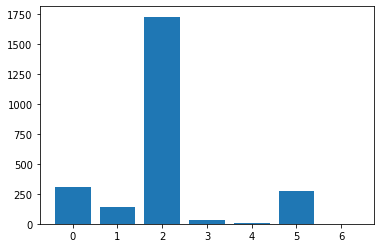

In [66]:
# Print nilai masing2 fitur dan plot dalam bar chart
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [67]:
# Perjelas nama masing2 fitur
for i in range(len(fs.scores_)):
	print('Feature %d: %s' % (i, X_train_cat.columns[i]))

Feature 0: workclass
Feature 1: education
Feature 2: marital_status
Feature 3: occupation
Feature 4: race
Feature 5: sex
Feature 6: native_country


Berdasarkan nilai Chi-Square, hanya fitur marital_status, workclass, sex dan education yg memiliki korelasi lumayan besar dengan target (income_bracket). Oleh karena itu, hanya kolom2 ini yg akan dipakai.

In [68]:
# Drop kolom2 kategorikal yg mempunyai korelasi rendah dengan target. Lakukan pada training set
X_train = X_train.drop(['occupation','race','native_country'], axis=1)

In [69]:
# Drop kolom2 kategorikal yg mempunyai korelasi rendah dengan target. Lakukan pada testing set
X_test = X_test.drop(['occupation','race','native_country'], axis=1)

Berikutnya akan dilakukan handling outliers yg dilakukan menggunakan metode capping dengan fungsi Winsorizer. Capping akan membatas dataset yg dianalisa sesuai batas2 data outlier tanpa menghapus data tsb. Kelebihan metode ini adalah data2 outlier tidak perlu dihapus sehingga berguna jika jumlah outliers cukup banyak. Metode capping menggunakan nilai IQR, karena kita mengasumsikan distribusi data tidak Gaussian.

In [70]:
# Lakukan handling outliers dengan metode capping menggunakan fungsi Winsorizer
windsoriser = Winsorizer(capping_method='iqr', 
                          tail='both', 
                          fold=1.5,
                          variables=['age', 'education_num', 'hours_per_week'])

windsoriser.fit(X_train)

# Store dataset hasil capping ke dalam X_train_t dan X_test_t 
X_train_t = windsoriser.transform(X_train)
X_test_t = windsoriser.transform(X_test)

In [71]:
# Tampilkan statistical desc masing2 dataset sebelum dan sesudah capping
print('X_train - Before Capping')
print(X_train.describe())
print('X_train - After Capping')
print(X_train_t.describe())
print('X_test - Before Capping')
print(X_test.describe())
print('X_test - After Capping')
print(X_test_t.describe())

X_train - Before Capping
                age  education_num  hours_per_week
count  15938.000000   15938.000000    15938.000000
mean       0.287855       0.601297        0.364529
std        0.190756       0.166777        0.118304
min        0.000000       0.000000        0.000000
25%        0.123288       0.533333        0.346939
50%        0.260274       0.600000        0.397959
75%        0.410959       0.733333        0.397959
max        1.000000       1.000000        1.000000
X_train - After Capping
                age  education_num  hours_per_week
count  15938.000000   15938.000000    15938.000000
mean       0.287542       0.604231        0.369780
std        0.189743       0.159011        0.055752
min        0.000000       0.233333        0.270408
25%        0.123288       0.533333        0.346939
50%        0.260274       0.600000        0.397959
75%        0.410959       0.733333        0.397959
max        0.842466       1.000000        0.474490
X_test - Before Capping
         

Terlihat jika nilai mean, std deviation, quintiles, min dan max pada dataset hasil capping sedikit berubah, namun jumlah dataset tetap sama dengan dataset sebelum capping. Artinya, proses capping aka sedikit merubah distribusi dataset

In [72]:
# Tampilkan X_train_t
X_train_t.head()

,workclass,education,marital_status,sex,age,education_num,hours_per_week
17167,Private,Bachelors,Previously Married,Female,0.520548,0.800000,0.397959
11438,Private,School,Married,Male,0.328767,0.266667,0.397959
2602,Self-employed,School,Previously Married,Male,0.794521,0.533333,0.270408
12952,Private,School,Never-married,Male,0.041096,0.533333,0.397959
18109,Public Servant,Bachelors,Married,Male,0.410959,0.600000,0.397959


Proses encoding selanjutnya adalah menggunakan OneHotEncoding (OHE). Berbeda dari sebelumnya, OHE tidak bertujuan utk mencari korelasi antar data, namun untuk merubah data kategorikal menjadi angka biner (1 atau 0) supaya bisa menjalani proses pemodelan. OHE dipilih karena 0 dan 1 menandakan label pada setiap kolom ada atau tidak. Jika angka selain 0 dan 1 digunakan (seperti pada LabelEncoder dan OrdinalEncoder), maka dikhawatirkan akan terjadi pembobotan lebih besar pada label dengan angka yg lebih besar. Itulah alasan mengapa metode OHE dipilih. Seperti step2 sebelumnya, utk melakukan OHE terlebih dahulu akan dilakukan pembagian dataset menjadi dataset numerik dan dataset kategorikal. Selanjutnya, dataset kategorikal akan dibagi lagi menjadi masing2 kolomnya (dalam kasus ini dibagi menjadi 4 kolom terpisah). Masing2 kolom tsb akan menjalani proses OHE secara terpisah. Kemudian dilakukan reset_index dan kolom2 tsb akan disatukan lagi dengan dataset numerik.

In [73]:
# Bagi training set dan testing set menjadi dataset numerik dan kategorikal
X_train_t_cat = X_train_t.select_dtypes(exclude='number')
X_train_t_num = X_train_t.select_dtypes(include='number')
X_test_t_cat = X_test_t.select_dtypes(exclude='number')
X_test_t_num = X_test_t.select_dtypes(include='number')

In [74]:
# Tampilkan dataset training berisi hanya data kategorikal
X_train_t_cat.head()

,workclass,education,marital_status,sex
17167,Private,Bachelors,Previously Married,Female
11438,Private,School,Married,Male
2602,Self-employed,School,Previously Married,Male
12952,Private,School,Never-married,Male
18109,Public Servant,Bachelors,Married,Male


In [75]:
# Buat dataset terpisah untuk masing2 kolom kategorikal
wc_train= X_train_t_cat[['workclass']]
ed_train= X_train_t_cat[['education']]
ms_train= X_train_t_cat[['marital_status']]
sx_train= X_train_t_cat[['sex']]
wc_test= X_test_t_cat[['workclass']]
ed_test= X_test_t_cat[['education']]
ms_test= X_test_t_cat[['marital_status']]
sx_test= X_test_t_cat[['sex']]

In [76]:
# Definisikan model OHE pada masing2 kolom terpisah tsb
enc_wc = OneHotEncoder(sparse=False)
enc_ed = OneHotEncoder(sparse=False)
enc_ms = OneHotEncoder(sparse=False)
enc_sx = OneHotEncoder(sparse=False)

In [77]:
# Lakukan transformasi data kategorikal menjadi data numerik menggunakan OHE pada masing2 kolom kategorikal, baik itu testing dan training set
wc_train_ohe = enc_wc.fit_transform(wc_train)
wc_test_ohe = enc_wc.fit_transform(wc_test)
ed_train_ohe = enc_ed.fit_transform(ed_train)
ed_test_ohe = enc_ed.fit_transform(ed_test)
ms_train_ohe = enc_ms.fit_transform(ms_train)
ms_test_ohe = enc_ms.fit_transform(ms_test)
sx_train_ohe = enc_sx.fit_transform(sx_train)
sx_test_ohe = enc_sx.fit_transform(sx_test)

In [78]:
# Tambahkan nama kolom pada dataset hasil OHE
wc_train_ohe_encoded = pd.DataFrame(wc_train_ohe, columns=enc_wc.categories_)
ed_train_ohe_encoded = pd.DataFrame(ed_train_ohe, columns=enc_ed.categories_)
ms_train_ohe_encoded = pd.DataFrame(ms_train_ohe, columns=enc_ms.categories_)
sx_train_ohe_encoded = pd.DataFrame(sx_train_ohe, columns=enc_sx.categories_)
wc_test_ohe_encoded = pd.DataFrame(wc_test_ohe, columns=enc_wc.categories_)
ed_test_ohe_encoded = pd.DataFrame(ed_test_ohe, columns=enc_ed.categories_)
ms_test_ohe_encoded = pd.DataFrame(ms_test_ohe, columns=enc_ms.categories_)
sx_test_ohe_encoded = pd.DataFrame(sx_test_ohe, columns=enc_sx.categories_)

In [79]:
# Lakukan reset_index supaya dataset bisa di-inner join
X_train_t_num.reset_index(drop=True, inplace=True)
X_test_t_num.reset_index(drop=True, inplace=True)

In [80]:
wc_train_ohe_encoded.reset_index(drop=True, inplace=True)
ed_train_ohe_encoded.reset_index(drop=True, inplace=True)
ms_train_ohe_encoded.reset_index(drop=True, inplace=True)
sx_train_ohe_encoded.reset_index(drop=True, inplace=True)
wc_test_ohe_encoded.reset_index(drop=True, inplace=True)
ed_test_ohe_encoded.reset_index(drop=True, inplace=True)
ms_test_ohe_encoded.reset_index(drop=True, inplace=True)
sx_test_ohe_encoded.reset_index(drop=True, inplace=True)


In [81]:
# Lakukan inner join pada dataset numerik dan dataset kategorikal hasil OHE
X_train_t_ohe = pd.merge(X_train_t_num, wc_train_ohe_encoded, left_index=True, right_index=True)
X_train_t_ohe = pd.merge(X_train_t_ohe, ed_train_ohe_encoded, left_index=True, right_index=True)
X_train_t_ohe = pd.merge(X_train_t_ohe, ms_train_ohe_encoded, left_index=True, right_index=True)
X_train_t_ohe = pd.merge(X_train_t_ohe, sx_train_ohe_encoded, left_index=True, right_index=True)
X_test_t_ohe = pd.merge(X_test_t_num, wc_test_ohe_encoded, left_index=True, right_index=True)
X_test_t_ohe = pd.merge(X_test_t_ohe, ed_test_ohe_encoded, left_index=True, right_index=True)
X_test_t_ohe = pd.merge(X_test_t_ohe, ms_test_ohe_encoded, left_index=True, right_index=True)
X_test_t_ohe = pd.merge(X_test_t_ohe, sx_test_ohe_encoded, left_index=True, right_index=True)

In [82]:
# Tampilkan training set hasil inner join setelah melalui proses OHE
X_train_t_ohe.head()

,age,education_num,hours_per_week,"( Private,)","( Public Servant,)","( Self-employed,)","( Bachelors,)","( Doctorate,)","( Masters,)","( School,)","( Vocation,)","( Married,)","( Never-married,)","( Previously Married,)","( Female,)","( Male,)"
0,0.520548,0.800000,0.397959,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.328767,0.266667,0.397959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.794521,0.533333,0.270408,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.041096,0.533333,0.397959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.410959,0.600000,0.397959,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [83]:
# Tampilkan testing set hasil inner join setelah melalui proses OHE
X_test_t_ohe.head()

,age,education_num,hours_per_week,"( Private,)","( Public Servant,)","( Self-employed,)","( Bachelors,)","( Doctorate,)","( Masters,)","( School,)","( Vocation,)","( Married,)","( Never-married,)","( Previously Married,)","( Female,)","( Male,)"
0,0.397260,0.866667,0.346939,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.287671,0.800000,0.397959,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.082192,0.600000,0.270408,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.068493,0.800000,0.270408,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.095890,0.800000,0.397959,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


# VI. Model Definition

Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

Sesuai deskripsi pada bagian Perkenalan, model yang akan digunakan adalah Logistic Regression dan SVM dengan hyperparameter rbf, linear dan plynomial masing2 dgn nilai C=1 dan C=100. Alasan menggunakan perbandingan SVM linear dengan radial dan polynomial adalah untuk mengetahui apakah profil hyperplane yg cocok untuk memecahkan problem klasifikasi pada dataset ini. Sedangkan nilai C=1 dan C=100 untuk mengetahui apakah tingkat regularisasi dapat mempengaruhi performance dari model.

In [84]:
# Definisikan model Logistic regression dalam logmod
logmod = LogisticRegression()

In [85]:
# Definisikan model SVM dengan kernel rbf dan C=1 dalam svc_rbf_1
svc_rbf_1=SVC(kernel='rbf',C=1)
# Definisikan model SVM dengan kernel rbf dan C=100 dalam svc_rbf_100
svc_rbf_100=SVC(kernel='rbf',C=100)

In [87]:
# Definisikan model SVM dengan kernel linear dan C=1 dalam svc_lin_1
svc_lin_1=SVC(kernel='linear',C=1)
#Definisikan model SVM dengan kernel linear dan C=100 dalam svc_lin_100
svc_lin_100=SVC(kernel='linear',C=100)

In [88]:
# Definisikan model SVM dengan kernel linear dan C=1 dalam svc_pol_1
svc_pol_1=SVC(kernel='poly',C=1)
# Definisikan model SVM dengan kernel linear dan C=100 dalam svc_pol_100
svc_pol_100=SVC(kernel='poly',C=100)

# VII. Model Training

Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

# Logistic Regression

In [89]:
%%time
# Fitting model logistic regression logmod ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam logm
logm = logmod.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


CPU times: user 227 ms, sys: 156 ms, total: 383 ms
Wall time: 236 ms


In [90]:
# Tampilkan koefisien dari model regresi logistik
logm.coef_

array([[ 2.19850472,  4.99126035,  6.63578698, -0.03769745,  0.11251599,
        -0.07364576, -0.01505496,  0.10242613,  0.16173044, -0.12287055,
        -0.12505828,  1.70673451, -1.10063628, -0.60492546, -0.02485381,
         0.02602658]])

In [ ]:
# Tampilkan intercept dari model regresi logistik
logm.intercept_

array([-8.49224218])

In [ ]:
%%time
# Buat prediksi model regresi logistik pada dataset training dan testing
y_pred_train_lm = logm.predict(X_train_t_ohe)
y_pred_test_lm = logm.predict(X_test_t_ohe)

CPU times: user 8.71 ms, sys: 8.17 ms, total: 16.9 ms
Wall time: 14.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


# SVM, Kernel = rbf, C=1

In [ ]:
%%time
# Fitting model SVM svc_rbf_1 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svcrbf1
svcrbf1 = svc_rbf_1.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 7.2 s, sys: 159 ms, total: 7.36 s
Wall time: 8.43 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=rbf, C=1) pada dataset training dan testing
y_pred_train_svc_rbf_1 = svcrbf1.predict(X_train_t_ohe)
y_pred_test_svc_rbf_1 = svcrbf1.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 8.04 s, sys: 3.26 ms, total: 8.04 s
Wall time: 8.02 s


# SVM, Kernel = rbf, C=100

In [ ]:
%%time
# Fitting model SVM svc_rbf_100 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svcrbf100
svcrbf100 = svc_rbf_100.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 21.3 s, sys: 61.5 ms, total: 21.4 s
Wall time: 22.8 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=rbf, C=100) pada dataset training dan testing
y_pred_train_svc_rbf_100 = svcrbf100.predict(X_train_t_ohe)
y_pred_test_svc_rbf_100 = svcrbf100.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 8.06 s, sys: 8.36 ms, total: 8.07 s
Wall time: 8.05 s


# SVM, Kernel = linear, C=1

In [ ]:
%%time
# Fitting model SVM svc_lin_1 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svclin1
svclin1 = svc_lin_1.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 4.45 s, sys: 37.7 ms, total: 4.49 s
Wall time: 4.49 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=linear, C=1) pada dataset training dan testing
y_pred_train_svc_lin_1 = svclin1.predict(X_train_t_ohe)
y_pred_test_svc_lin_1 = svclin1.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 2.77 s, sys: 2.89 ms, total: 2.78 s
Wall time: 2.76 s


# SVM, Kernel = linear, C=100

In [ ]:
%%time
# Fitting model SVM svc_lin_100 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svclin100
svclin100 = svc_lin_100.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 36.4 s, sys: 44 ms, total: 36.4 s
Wall time: 36.4 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=linear, C=100) pada dataset training dan testing
y_pred_train_svc_lin_100 = svclin100.predict(X_train_t_ohe)
y_pred_test_svc_lin_100 = svclin100.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 2.73 s, sys: 8.94 ms, total: 2.74 s
Wall time: 2.74 s


# SVM, Kernel = poly, C=1

In [ ]:
%%time
# Fitting model SVM svc_pol_1 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svcpol1
svcpol1 = svc_pol_1.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 6 s, sys: 33 ms, total: 6.03 s
Wall time: 6.03 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=poly, C=1) pada dataset training dan testing
y_pred_train_svc_pol_1 = svcpol1.predict(X_train_t_ohe)
y_pred_test_svc_pol_1 = svcpol1.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 3 s, sys: 4.96 ms, total: 3 s
Wall time: 2.99 s


# SVM, Kernel = poly, C=100

In [ ]:
%%time
# Fitting model SVM svc_pol_100 ke dalam dataset X_train_t_ohe dan y_train_enc. Store model ke dalam svcpol100
svcpol100 = svc_pol_100.fit(X_train_t_ohe,y_train_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 42.2 s, sys: 62.3 ms, total: 42.2 s
Wall time: 43.2 s


In [ ]:
%%time
# Buat prediksi model SVM (kernel=poly, C=100) pada dataset training dan testing
y_pred_train_svc_pol_100 = svcpol100.predict(X_train_t_ohe)
y_pred_test_svc_pol_100 = svcpol100.predict(X_test_t_ohe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


CPU times: user 2.89 s, sys: 5.01 ms, total: 2.9 s
Wall time: 2.88 s


Secara keseluruhan, model SVM dengan hyperparameter C=100 memiliki waktu training model yang jauh lebih lama dibandingkan SVM dengan C=1

# VIII. Model Evaluation

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya.

# Logistic Regression

In [ ]:
# Tampilkan skor akurasi model regresi logistik
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_lm))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_lm))

accuracy score train :  0.8408206801355251
accuracy score test :  0.8466750313676286


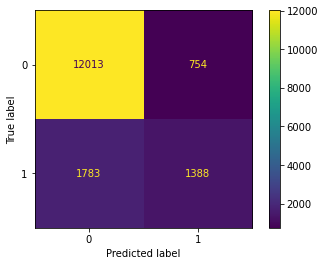

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_lm = confusion_matrix(y_train_enc,y_pred_train_lm, labels=logm.classes_)
disp_train_lm = ConfusionMatrixDisplay(confusion_matrix=cm_train_lm, display_labels=logm.classes_)

disp_train_lm.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_lm))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12767
           1       0.65      0.44      0.52      3171

    accuracy                           0.84     15938
   macro avg       0.76      0.69      0.71     15938
weighted avg       0.83      0.84      0.83     15938



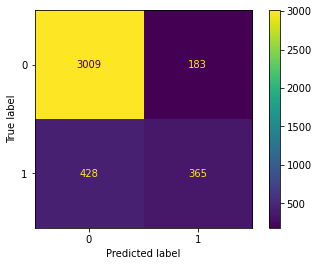

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_lm = confusion_matrix(y_test_enc,y_pred_test_lm, labels=logm.classes_)
disp_test_lm = ConfusionMatrixDisplay(confusion_matrix=cm_test_lm, display_labels=logm.classes_)

disp_test_lm.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset test
print(classification_report(y_test_enc,y_pred_test_lm))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3192
           1       0.67      0.46      0.54       793

    accuracy                           0.85      3985
   macro avg       0.77      0.70      0.73      3985
weighted avg       0.83      0.85      0.84      3985



# SVM, Kernel = rbf, C=1

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=rbf, C=1
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_rbf_1))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_rbf_1))

accuracy score train :  0.8409461663947798
accuracy score test :  0.8421580928481807


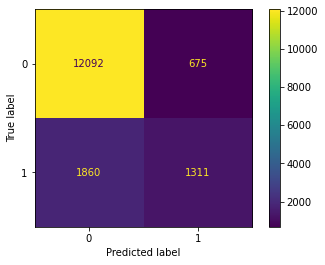

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_rbf_1 = confusion_matrix(y_train_enc,y_pred_train_svc_rbf_1, labels=logm.classes_)
disp_train_svc_rbf_1 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_rbf_1, display_labels=logm.classes_)

disp_train_svc_rbf_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_rbf_1))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12767
           1       0.66      0.41      0.51      3171

    accuracy                           0.84     15938
   macro avg       0.76      0.68      0.71     15938
weighted avg       0.83      0.84      0.83     15938



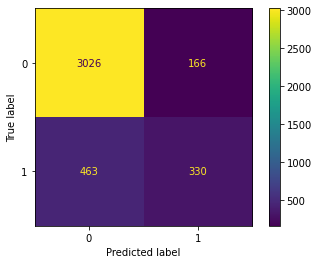

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_rbf_1 = confusion_matrix(y_test_enc,y_pred_test_svc_rbf_1, labels=logm.classes_)
disp_test_svc_rbf_1 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_rbf_1, display_labels=logm.classes_)

disp_test_svc_rbf_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_rbf_1))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3192
           1       0.67      0.42      0.51       793

    accuracy                           0.84      3985
   macro avg       0.77      0.68      0.71      3985
weighted avg       0.83      0.84      0.83      3985



# SVM, Kernel = rbf, C=100

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=rbf, C=100
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_rbf_100))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_rbf_100))

accuracy score train :  0.8497929476722299
accuracy score test :  0.8489335006273526


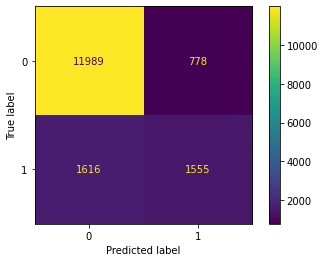

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_rbf_100 = confusion_matrix(y_train_enc,y_pred_train_svc_rbf_100, labels=logm.classes_)
disp_train_svc_rbf_100 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_rbf_100, display_labels=logm.classes_)

disp_train_svc_rbf_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_rbf_100))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12767
           1       0.67      0.49      0.57      3171

    accuracy                           0.85     15938
   macro avg       0.77      0.71      0.74     15938
weighted avg       0.84      0.85      0.84     15938



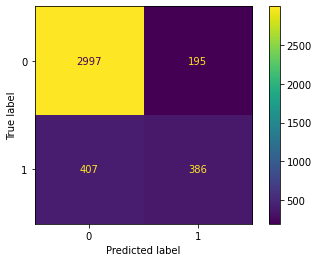

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_rbf_100 = confusion_matrix(y_test_enc,y_pred_test_svc_rbf_100, labels=logm.classes_)
disp_test_svc_rbf_100 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_rbf_100, display_labels=logm.classes_)

disp_test_svc_rbf_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_rbf_100))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3192
           1       0.66      0.49      0.56       793

    accuracy                           0.85      3985
   macro avg       0.77      0.71      0.74      3985
weighted avg       0.84      0.85      0.84      3985



# SVM, Kernel = linear, C=1

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=linear, C=1
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_lin_1))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_lin_1))

accuracy score train :  0.8395658175429791
accuracy score test :  0.8409033877038896


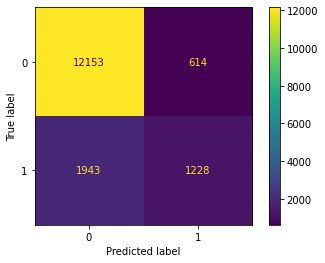

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_lin_1 = confusion_matrix(y_train_enc,y_pred_train_svc_lin_1, labels=logm.classes_)
disp_train_svc_lin_1 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_lin_1, display_labels=logm.classes_)

disp_train_svc_lin_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_lin_1))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     12767
           1       0.67      0.39      0.49      3171

    accuracy                           0.84     15938
   macro avg       0.76      0.67      0.70     15938
weighted avg       0.82      0.84      0.82     15938



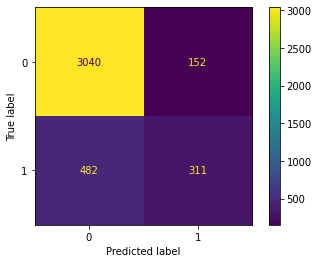

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_lin_1 = confusion_matrix(y_test_enc,y_pred_test_svc_lin_1, labels=logm.classes_)
disp_test_svc_lin_1 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_lin_1, display_labels=logm.classes_)

disp_test_svc_lin_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_lin_1))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      3192
           1       0.67      0.39      0.50       793

    accuracy                           0.84      3985
   macro avg       0.77      0.67      0.70      3985
weighted avg       0.83      0.84      0.82      3985



# SVM, Kernel = linear, C=100

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=linear, C=100
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_lin_100))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_lin_100))

accuracy score train :  0.8395658175429791
accuracy score test :  0.8409033877038896


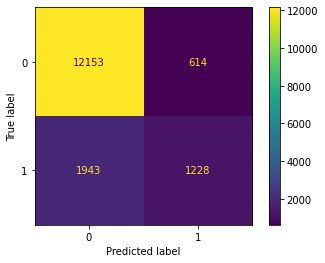

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_lin_100 = confusion_matrix(y_train_enc,y_pred_train_svc_lin_100, labels=logm.classes_)
disp_train_svc_lin_100 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_lin_100, display_labels=logm.classes_)

disp_train_svc_lin_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_lin_100))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     12767
           1       0.67      0.39      0.49      3171

    accuracy                           0.84     15938
   macro avg       0.76      0.67      0.70     15938
weighted avg       0.82      0.84      0.82     15938



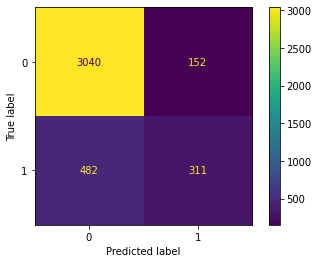

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_lin_100 = confusion_matrix(y_test_enc,y_pred_test_svc_lin_100, labels=logm.classes_)
disp_test_svc_lin_100 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_lin_100, display_labels=logm.classes_)

disp_test_svc_lin_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_lin_100))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      3192
           1       0.67      0.39      0.50       793

    accuracy                           0.84      3985
   macro avg       0.77      0.67      0.70      3985
weighted avg       0.83      0.84      0.82      3985



# SVM, Kernel = poly, C=1

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=poly, C=1
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_pol_1))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_pol_1))

accuracy score train :  0.8400677625799975
accuracy score test :  0.840150564617315


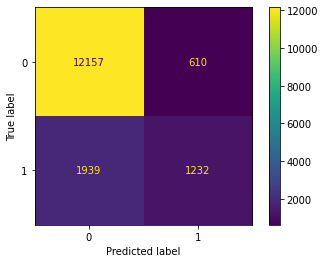

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_pol_1 = confusion_matrix(y_train_enc,y_pred_train_svc_pol_1, labels=logm.classes_)
disp_train_svc_pol_1 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_pol_1, display_labels=logm.classes_)

disp_train_svc_pol_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_pol_1))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91     12767
           1       0.67      0.39      0.49      3171

    accuracy                           0.84     15938
   macro avg       0.77      0.67      0.70     15938
weighted avg       0.82      0.84      0.82     15938



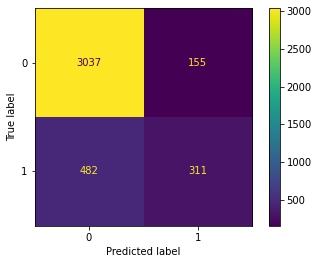

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_pol_1 = confusion_matrix(y_test_enc,y_pred_test_svc_pol_1, labels=logm.classes_)
disp_test_svc_pol_1 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_pol_1, display_labels=logm.classes_)

disp_test_svc_pol_1.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_pol_1))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      3192
           1       0.67      0.39      0.49       793

    accuracy                           0.84      3985
   macro avg       0.77      0.67      0.70      3985
weighted avg       0.82      0.84      0.82      3985



# SVM, Kernel = poly, C=100

In [ ]:
# Tampilkan skor akurasi model SVM, kernel=poly, C=100
print('accuracy score train : ',accuracy_score(y_train_enc,y_pred_train_svc_pol_100))
print('accuracy score test : ',accuracy_score(y_test_enc,y_pred_test_svc_pol_100))

accuracy score train :  0.845714644246455
accuracy score test :  0.8441656210790465


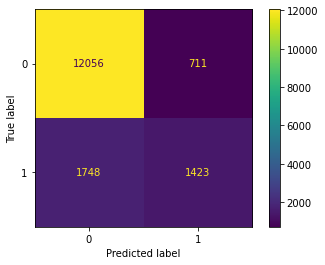

In [ ]:
# Tampilkan confusion matrix pada dataset training
cm_train_svc_pol_100 = confusion_matrix(y_train_enc,y_pred_train_svc_pol_100, labels=logm.classes_)
disp_train_svc_pol_100 = ConfusionMatrixDisplay(confusion_matrix=cm_train_svc_pol_100, display_labels=logm.classes_)

disp_train_svc_pol_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset training
print(classification_report(y_train_enc,y_pred_train_svc_pol_100))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12767
           1       0.67      0.45      0.54      3171

    accuracy                           0.85     15938
   macro avg       0.77      0.70      0.72     15938
weighted avg       0.83      0.85      0.83     15938



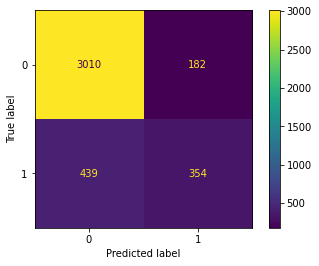

In [ ]:
# Tampilkan confusion matrix pada dataset testing
cm_test_svc_pol_100 = confusion_matrix(y_test_enc,y_pred_test_svc_pol_100, labels=logm.classes_)
disp_test_svc_pol_100 = ConfusionMatrixDisplay(confusion_matrix=cm_test_svc_pol_100, display_labels=logm.classes_)

disp_test_svc_pol_100.plot()
plt.show()

In [ ]:
# Tampilkan classification report pada dataset testing
print(classification_report(y_test_enc,y_pred_test_svc_pol_100))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3192
           1       0.66      0.45      0.53       793

    accuracy                           0.84      3985
   macro avg       0.77      0.69      0.72      3985
weighted avg       0.83      0.84      0.83      3985



# Summary Model Evaluation

Keseluruhan model tsb memiliki pola sebagai berikut: Nilai f1-score untuk label 0 (income < 50K) selalu lebih besar dibandingkan nilai f-score untuk label 1 (income => 50K). Perbandingan nilai f-score untuk label 0 adalah antara 0,8-0,9 dan nilai f-score untuk label 1 adalah antara 0,4-0,5. Perbandingan tersebut cukup jauh. Artinya model Logistic Regression dan SVM jauh lebih baik dalam memprediksi income dengan nilai < 50K dibandingkan income dengan nilai => 50K. Hal ini cukup menggembirakan untuk dataset ini dimana 80% data adalah income dengan nilai < 50K. Namun, performance model bisa dikatakan cukup buruk dalam memprediksi income dengan nilai => 50K. Apabila model digunakan untuk memprediksi dataset lain dengan komposisi income => 50K lebih besar, maka akan sering terjadi kesalahan prediksi.

Nilai terbaik pada Confusion Matrix berada pada skor recall untuk label 0 dan precision untuk label 0. Angka untuk label 0 sudah sangat baik untuk recall (kisaran 0,9) dan precision (kisaran 0,8). Dari perbandingan ini, kita bisa menduga jika angka false positive (FP) lebih besar dari false negative (FN) pada kasus prediksi label 0. Artinya, model mempunyai kekurangan karena banyak terjadi kesalahan prediksi label 1 yang ternyata adalah label 0. Di sisi lain, nilai terburuk secara konsisten berada pada skor recall pada label 1 (kisaran 0,4) dibandingkan skor precision pada label 1 (kisaran 0,6). Perbandingan ini kebalikan dengan skor pada label 0. Pada label 1, angka FN lebih besar dari FP. Artinya, model banyak melakukan salah prediksi label 0 yang ternyata adalah label 1. Mungkin model yang dihasilkan terlalu dipengaruhi oleh kondisi dataset itu sendiri, dimana 80% label income adalah 0 (<= 50K). Jika hal itu benar, maka model mengalami overfitting, sehingga skor f-1 pada label 1 lebih rendah.  

Dilihat dari nilai macro-average, model dengan nilai terbaik adalah SVM kernel rbf dan C=100 dengan skor 0.74. Namun, skor ini tidak berbeda jauh dengan model Logistic Regression dan model2 SVM lainnya karena range model2 tsb berada pada 0.7-0.73. Secara umum nilai macro-average pada training set dan testing set juga hampir sama. Penggunaan hyperparameter C pada SVM berpengaruh hanya pada kernel rbf dan polynomial. Peningkatan nilai C dari 1 ke 100 cenderung memperbaiki nilai macro-average, namun hal ini diimbangi dengan waktu training dan prediksi model yang jauh lebih lama pada nilai C=100. Model SVM kernel linear adalah model dengan performance terburuk dengan nilai macro-average 0,7. Performa tsb tidak dipengaruhi oleh pemilihan nilai C. Bahkan model Logistic regression yg lebih sederhana masih memiliki performance yg sedikit lebih baik daripada model SVM linear.

Berikutnya, mari kita buat tabel perbandingan accuracy score.

In [ ]:
pd.DataFrame({'Acuracy Score (Train)': [accuracy_score(y_train_enc,y_pred_train_lm), accuracy_score(y_train_enc,y_pred_train_svc_rbf_1),
                                       accuracy_score(y_train_enc,y_pred_train_svc_rbf_100), accuracy_score(y_train_enc,y_pred_train_svc_lin_1),
                                       accuracy_score(y_train_enc,y_pred_train_svc_lin_100), accuracy_score(y_train_enc,y_pred_train_svc_pol_1),
                                        accuracy_score(y_train_enc,y_pred_train_svc_pol_100),], 
              'Acuracy Score (Test)': [accuracy_score(y_test_enc,y_pred_test_lm), accuracy_score(y_test_enc,y_pred_test_svc_rbf_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_rbf_100), accuracy_score(y_test_enc,y_pred_test_svc_lin_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_lin_100), accuracy_score(y_test_enc,y_pred_test_svc_pol_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_pol_100)
                                        ]}, index=['Logistic Regression','SVM, Kernel=rbf, C=1','SVM, Kernel=rbf, C=100',
                                                   'SVM, Kernel=linear, C=1','SVM, Kernel=linear, C=100','SVM, Kernel=poly, C=1',
                                                   'SVM, Kernel=poly, C=100'])	


,Acuracy Score (Train),Acuracy Score (Test)
Logistic Regression,0.840821,0.846675
"SVM, Kernel=rbf, C=1",0.840946,0.842158
"SVM, Kernel=rbf, C=100",0.849793,0.848934
"SVM, Kernel=linear, C=1",0.839566,0.840903
"SVM, Kernel=linear, C=100",0.839566,0.840903
"SVM, Kernel=poly, C=1",0.840068,0.840151
"SVM, Kernel=poly, C=100",0.845715,0.844166


Sejalan dengan hasil analisa sebelumnya, nilai accuracy score untuk SVM kernel rbf dengan C=100 adalah yang tertinggi (0.848-0.849). Nilai accuracy score untuk SVM kernel linear adalah yang terendah (0.839-0.84).

# IX. Model Inference

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

Langkah pertama adalah membuat sampel untuk dataset inference. Sampel akan menggunakan dataset original (df_1). Namun, dataset tsb harus menjalani encoding ulang untuk fitur kategorikal (OneHotEncoder) dan untuk target (LabelEncoder). Berikut ini adalah step-by-step untuk membuat sampel inference. Output akhir dari dataset inference adalah X_inf dan y_inf. Langkah2nya sama dengan proses sebelumnya

In [ ]:
X_inf_num = df_1[['age','education_num','hours_per_week']]

In [ ]:
y_inf = df_1[['income_bracket']]

In [ ]:
wc_inf= df_1[['workclass']]
ed_inf= df_1[['education']]
ms_inf= df_1[['marital_status']]
sx_inf= df_1[['sex']]

In [ ]:
enc_wc_i = OneHotEncoder(sparse=False)
enc_ed_i = OneHotEncoder(sparse=False)
enc_ms_i = OneHotEncoder(sparse=False)
enc_sx_i = OneHotEncoder(sparse=False)

In [ ]:
wc_inf_ohe = enc_wc_i.fit_transform(wc_inf)
ed_inf_ohe = enc_ed_i.fit_transform(ed_inf)
ms_inf_ohe = enc_ms_i.fit_transform(ms_inf)
sx_inf_ohe = enc_sx_i.fit_transform(sx_inf)

In [ ]:
wc_inf_ohe_encoded = pd.DataFrame(wc_inf_ohe, columns=enc_wc_i.categories_)
ed_inf_ohe_encoded = pd.DataFrame(ed_inf_ohe, columns=enc_ed_i.categories_)
ms_inf_ohe_encoded = pd.DataFrame(ms_inf_ohe, columns=enc_ms_i.categories_)
sx_inf_ohe_encoded = pd.DataFrame(sx_inf_ohe, columns=enc_sx_i.categories_)

In [ ]:
wc_inf_ohe_encoded.reset_index(drop=True, inplace=True)
ed_inf_ohe_encoded.reset_index(drop=True, inplace=True)
ms_inf_ohe_encoded.reset_index(drop=True, inplace=True)
sx_inf_ohe_encoded.reset_index(drop=True, inplace=True)

In [ ]:
X_inf = pd.merge(X_inf_num, wc_inf_ohe_encoded, left_index=True, right_index=True)
X_inf = pd.merge(X_inf, ed_inf_ohe_encoded, left_index=True, right_index=True)
X_inf = pd.merge(X_inf, ms_inf_ohe_encoded, left_index=True, right_index=True)
X_inf = pd.merge(X_inf, sx_inf_ohe_encoded, left_index=True, right_index=True)

In [ ]:
leinf = LabelEncoder()
leinf.fit(y_train)
y_inf = leinf.transform(y_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Tampilkan dataset fitur inference X_inf
X_inf.head()

,age,education_num,hours_per_week,"( Private,)","( Public Servant,)","( Self-employed,)","( Bachelors,)","( Doctorate,)","( Masters,)","( School,)","( Vocation,)","( Married,)","( Never-married,)","( Previously Married,)","( Female,)","( Male,)"
0,37,8,33,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,39,9,54,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,29,9,18,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,64,9,21,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,31,9,18,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Tampilkan dataset target inference y_inf
y_inf

array([0, 1, 0, ..., 0, 0, 1])

Berikutnya adalah menggunakan model yang sebelumnya telah dibuat untuk memprediksi dataset inference

In [ ]:
# Buat prediksi model logm pada dataset inference
y_pred_lm_inf = logm.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=rbf, C=1) pada dataset inference
y_pred_svc_rbf_1_inf = svcrbf1.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=rbf, C=100) pada dataset inference
y_pred_svc_rbf_100_inf = svcrbf100.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=linear, C=1) pada dataset inference
y_pred_svc_lin_1_inf = svclin1.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=linear, C=100) pada dataset inference
y_pred_svc_lin_100_inf = svclin100.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=poly, C=1) pada dataset inference
y_pred_svc_pol_1_inf = svcpol1.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# Buat prediksi model SVM (kernel=poly, C=100) pada dataset inference
y_pred_svc_pol_100_inf = svcpol100.predict(X_inf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


Hasil accuracy score pada berbagai model diatas yang diuji pada dataset inference akan ditambahkan ke tabel accuracy score berikut ini:

In [ ]:
pd.DataFrame({'Acuracy Score (Train)': [accuracy_score(y_train_enc,y_pred_train_lm), accuracy_score(y_train_enc,y_pred_train_svc_rbf_1),
                                       accuracy_score(y_train_enc,y_pred_train_svc_rbf_100), accuracy_score(y_train_enc,y_pred_train_svc_lin_1),
                                       accuracy_score(y_train_enc,y_pred_train_svc_lin_100), accuracy_score(y_train_enc,y_pred_train_svc_pol_1),
                                        accuracy_score(y_train_enc,y_pred_train_svc_pol_100)], 
              'Acuracy Score (Test)': [accuracy_score(y_test_enc,y_pred_test_lm), accuracy_score(y_test_enc,y_pred_test_svc_rbf_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_rbf_100), accuracy_score(y_test_enc,y_pred_test_svc_lin_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_lin_100), accuracy_score(y_test_enc,y_pred_test_svc_pol_1),
                                       accuracy_score(y_test_enc,y_pred_test_svc_pol_100)],
             'Acuracy Score (Inference)': [accuracy_score(y_inf,y_pred_lm_inf), accuracy_score(y_inf,y_pred_svc_rbf_1_inf),
                                       accuracy_score(y_inf,y_pred_svc_rbf_100_inf), accuracy_score(y_inf,y_pred_svc_lin_1_inf),
                                       accuracy_score(y_inf,y_pred_svc_lin_100_inf), accuracy_score(y_inf,y_pred_svc_pol_1_inf),
                                       accuracy_score(y_inf,y_pred_svc_pol_100_inf)
                                        ]}, index=['Logistic Regression','SVM, Kernel=rbf, C=1','SVM, Kernel=rbf, C=100',
                                                   'SVM, Kernel=linear, C=1','SVM, Kernel=linear, C=100','SVM, Kernel=poly, C=1',
                                                   'SVM, Kernel=poly, C=100'])	


,Acuracy Score (Train),Acuracy Score (Test),Acuracy Score (Inference)
Logistic Regression,0.840821,0.846675,0.198966
"SVM, Kernel=rbf, C=1",0.840946,0.842158,0.801034
"SVM, Kernel=rbf, C=100",0.849793,0.848934,0.801034
"SVM, Kernel=linear, C=1",0.839566,0.840903,0.198966
"SVM, Kernel=linear, C=100",0.839566,0.840903,0.198966
"SVM, Kernel=poly, C=1",0.840068,0.840151,0.801034
"SVM, Kernel=poly, C=100",0.845715,0.844166,0.800482


Hasil diatas cukup mengejutkan dimana accuracy score hasil inference selalu lebih rendah (0.80) dengan accuracy score pada training dan testing set pada setiap model. Yg paling parah adalah pada model logistic regression dan SVM kernel linear karena nilai accuracy score drop ke angka 0.198 ketika model diuji pada inference set. Hal ini mengindikasikan persebaran data pada dataset census_adult_income tidak dapat dipisahkan menggunakan linear hyperplane, namun lebih cocok menggunakan polynomial atau radial hyperplane. Pada persebaran data seperti ini, meningkatkan nilai C akan bermanfaat pada model SVM rbf dan polynomial karena nilai C meningkatkan kadar regularization dengan nilai C yg lebih tinggi akan membuat margin SVM semakin pendek. Namun, secara keseluruhan model mengalami overfitting krn hasil accuracy score pada inference set lebih rendah, dimana tingkat overfit paling parah terjadi pada model logistic regression dan SVM kernel linear.

# X. Kesimpulan

Pada bagian terakhir ini, harus berisi kesimpulan yang mencerminkan hasil yang didapat dengan objective yang sudah ditulis di bagian pengenalan.

Analisa dan prediksi pada dataset census_adult_income telah berhasil dilaksanakan. Setelah melalui personal judgement dan uji korelasi Chi-Square, jumlah fitur dikurangi menjadi 7, terdiri dari 4 fitur kategorikal (workclass, education, marital_status, sex) dan 3 fitur numerik (age, education_num, hours_per_week). Fitur kategorikal diubah nilainya menggunakan OHE, karena OHE mengubah label menjadi angka biner, sehingga tidak terjadi pembobotan pada label tertentu. Scaling pada data numerik menggunakan MinMaxScaler, karena menghasilkan scale antara 0-1. Pemodelan dilakukan menggunakan metode Logistic Regression dan SVM dengan variasi hyperparameter kernel rbf, linear dan polynomial serta C=1 dan C=100.

Secara keseluruhan, nilai f1-score untuk label 0 (income < 50K) selalu lebih besar dibandingkan nilai f-score untuk label 1 (income => 50K). Perbandingan nilai f-score untuk label 0 adalah antara 0,8-0,9 dan nilai f-score untuk label 1 adalah antara 0,4-0,5. Artinya model Logistic Regression dan SVM jauh lebih baik dalam memprediksi income dengan nilai < 50K dibandingkan income dengan nilai => 50K. 

Nilai terbaik pada Confusion Matrix berada pada skor recall untuk label 0 dan precision untuk label 0. Angka untuk label 0 untuk recall (kisaran 0,9) dan untuk precision (kisaran 0,8) sangatlah baik. Di sisi lain, nilai terburuk secara konsisten berada pada skor recall pada label 1 (kisaran 0,4) dibandingkan skor precision pada label 1 (kisaran 0,6).

Dilihat dari nilai macro-average, model dengan nilai terbaik adalah SVM kernel rbf dan C=100 dengan skor 0.74. Namun, skor ini tidak berbeda jauh dengan model Logistic Regression dan model2 SVM lainnya karena range model2 tsb berada pada 0.7-0.73. Secara umum nilai macro-average pada training set dan testing set juga hampir sama. Penggunaan hyperparameter C pada SVM berpengaruh hanya pada kernel rbf dan polynomial. Peningkatan nilai C dari 1 ke 100 cenderung memperbaiki nilai macro-average, namun hal ini diimbangi dengan waktu training dan prediksi model yang jauh lebih lama pada nilai C=100. 

Model SVM kernel linear adalah model dengan performance terburuk secara macro-average dengan nilai 0,7. Performa tsb tidak dipengaruhi oleh pemilihan nilai C. Bahkan model Logistic regression yg lebih sederhana masih memiliki performance yg sedikit lebih baik daripada model SVM linear.

Nilai accuracy score untuk SVM kernel rbf dengan C=100 adalah yang tertinggi (0.848-0.849). Nilai accuracy score untuk SVM kernel linear adalah yang terendah (0.839-0.84). Meskipun kedua hasil ini cukup baik karena masih berada diatas 0,8, model perlu diuji pada inference set untuk mengetahui apakah nilai tersebut konsisten.

Setelah diuji pada inference set, rupanya terjadi penurunan accuracy score menjadi 0.8 pada model SVM kernel rbf dan polynomial. Penurunan paling parah terjadi pada model Logistic Regression dan SVM kernel linear dimana angka accuracy score drop menjadi 0.198 ketika model diuji pada inference set. Hasil2 ini mengindikasikan 2 kesimpulan penting:
1. Model mengalami overfitting dimana skor pada training dan testing set selalu lebih tinggi dibandingkan dengan inference set. Kondisi ini juga dibuktikan dengan f-1 score untuk label 0 yang selalu lebih besar dibanding untuk label 1, sementara dataset mengandung 80% data target termasuk ke dalam label 0.

2. Model dengan hyperplane linear seperti Linear Logistic dan SVM kernel linear tidak cocok untuk diterapkan pada dataset ini, karena karakteristik persebaran data cenderung dipisahkan dengan garis yang polynomial in nature. Hal ini dibuktikan dengan skore model SVM kernel rbf dan polynomial yang selalu lebih tinggi baik di training set, testing set dan inference set. Oleh karena itu, meningkatkan hyperparameter C akan meningkatkan performance kedua jenis model ini, meskipun meningkatkan nilai C akan membuat waktu training dan prediction model menjadi jauh lebih lama.



# Pertanyaan

1. Apakah yang dimaksud dengan coeficient pada logistic regression?

Koefisien adalah pengali (Bn) pada variabel (xn) pada rumus regresi logistik:

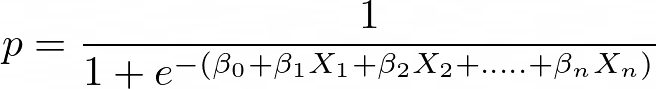

Rumus logistic regression diatas menentukan probabilitas (p) apakah klasifikasi termasuk label 1 atau 0. Jika p diatas 0.5, dapat dikatakan label akan diprediksi sebagai label 1.
2. Apakah yang dimaksud dengan Support Vector pada SVM?

Support vector adalah titik2 di sekitar hyperplane yang menentukan posisi dan orientasi dari hyperplane tsb
3. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

Kernel adalah fungsi matematika yang digunakan SVM untuk memecahkan problem klasifikasi. Contohnya, kernel linear akan menghasilkan solusi berbentuk hyperplane yang linear untuk mengklasifikasikan masing2 label. Sebaliknya, kernel radial akan men-transform data menjadi dimensi yang lebih besar, sehingga problem klasifikasi bisa dipecahkan. Kernel polynomial akan menghasilkan solusi hyperplane yang berbentuk polynomial (melengkung). Fungsi dari parameter kernel adalah untuk membentuk garis pembatas hyperplane untuk memisahkan data menjadi klasifikasi yg berbeda.